In [1]:
import math
import warnings

from IPython.display import display
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn import linear_model
from scipy.stats import boxcox
#import statsmodels.formula.api as smf

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.
warnings.filterwarnings(
    action="ignore",
    module="scipy",
    message="^internal gelsd"
)

In [2]:
# Acquire, load, and preview the data.
data = pd.read_csv('https://tf-curricula-prod.s3.amazonaws.com/data-science/Advertising.csv')
display(data.head())

# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = data['Sales'].values.reshape(-1, 1)
X = data[['TV','Radio','Newspaper']]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))

,Unnamed: 0,TV,Radio,Newspaper,Sales
0,1,230.100,37.800,69.200,22.100
1,2,44.500,39.300,45.100,10.400
2,3,17.200,45.900,69.300,9.300
3,4,151.500,41.300,58.500,18.500
4,5,180.800,10.800,58.400,12.900



Coefficients: 
 [[ 0.04576465  0.18853002 -0.00103749]]

Intercept: 
 [2.93888937]

R-squared:
0.8972106381789521


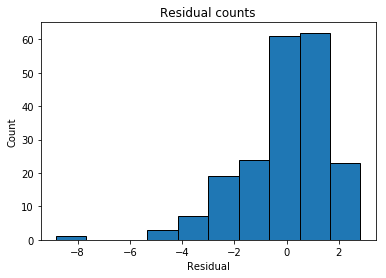

In [3]:
# Extract predicted values.
predicted = regr.predict(X).ravel()
actual = data['Sales']

# Calculate the error, also called the residual.
residual = actual - predicted

# This looks a bit concerning.
plt.hist(residual, edgecolor='k')
plt.title('Residual counts')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

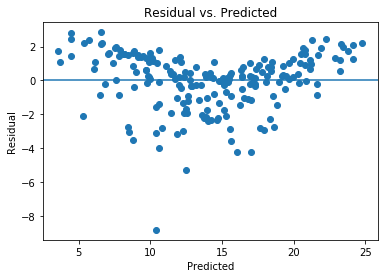

In [4]:
plt.scatter(predicted, residual)
plt.xlabel('Predicted')
plt.ylabel('Residual')
plt.axhline(y=0)
plt.title('Residual vs. Predicted')
plt.show()

# Hm... looks a bit concerning.

In [5]:
correlation_matrix = X.corr()
display(correlation_matrix)

,TV,Radio,Newspaper
TV,1.000,0.055,0.057
Radio,0.055,1.000,0.354
Newspaper,0.057,0.354,1.000


# Fixing Assumptions

#### We have a problem with heteroscedasticity and multivariate non-normality

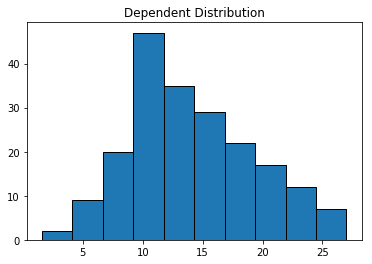

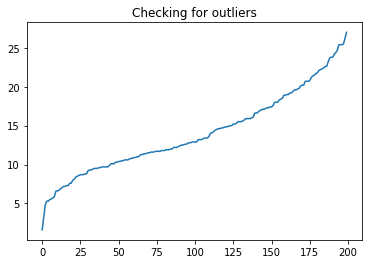

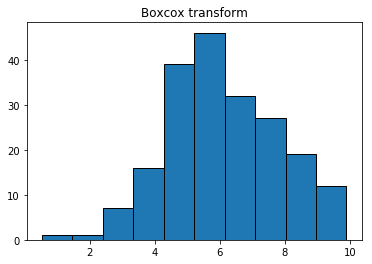

In [6]:
plt.hist(data.Sales, edgecolor='k')
plt.title('Dependent Distribution')
plt.show()

a = data.Sales.sort_values().reset_index()
plt.plot(a.Sales)
plt.title('Checking for outliers')
plt.show()

# let's try a boxcox transform to fix the dependent distribution
bc_transform = boxcox(data.Sales)
plt.hist(bc_transform[0], edgecolor='k')
plt.title('Boxcox transform')
plt.show()

In [7]:
def linregfunc(X, Y):

    regr.fit(X, Y)
    print('\nCoefficients: \n', regr.coef_)
    print('\nIntercept: \n', regr.intercept_)
    print('\nR-squared:')
    print(regr.score(X, Y))
    
    # Extract predicted values.
    predicted = regr.predict(X).ravel()
    actual = Y

    # Calculate the error, also called the residual.
    residual = actual - predicted
    
    # Plot residuals to see the multivariate normality
    plt.hist(residual, edgecolor='k')
    plt.title('Residual counts')
    plt.xlabel('Residual')
    plt.ylabel('Count')
    plt.show()
    
    # Plot the predicted values vs residuals to check homoscedasticity
    plt.scatter(predicted, residual)
    plt.xlabel('Predicted')
    plt.ylabel('Residual')
    plt.axhline(y=0)
    plt.title('Residual vs. Predicted')
    plt.show()


Coefficients: 
 [0.0154768  0.0585134  0.00010463]

Intercept: 
 2.449969676387673

R-squared:
0.8827857172057532


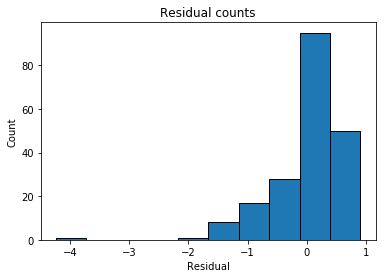

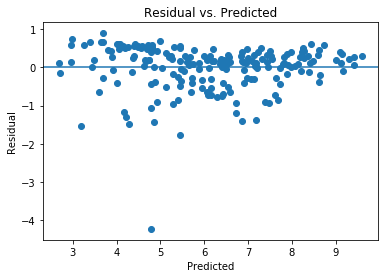

In [8]:
linregfunc(X, bc_transform[0])

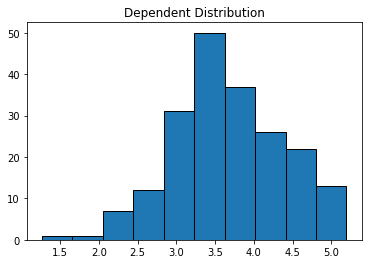


Coefficients: 
 [6.35315463e-03 2.35844016e-02 9.53200418e-05]

Intercept: 
 2.191350680248099

R-squared:
0.8766526458668338


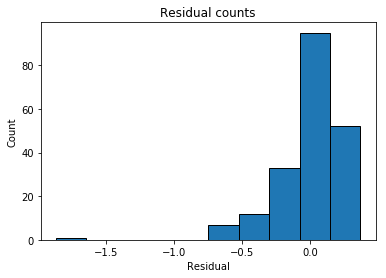

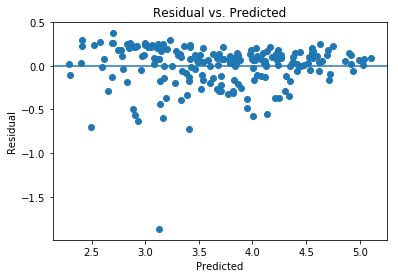

In [9]:
# still have some outliers in the residual vs predicted indicating we stil have heteroscedasticity and the distribution of 
# residuals is still non-normal

plt.hist(np.sqrt(data.Sales), edgecolor='k')
plt.title('Dependent Distribution')
plt.show()

sqroot = np.sqrt(data.Sales)
linregfunc(X, sqroot)

Using the square root to transform the dependent variable we have a much tighter homoscedasticity.  Now let's see what we can do about that one outlier.

In [10]:
def findresidualoutlier(X, Y):
    regr.fit(X, Y)
    predicted = regr.predict(X).ravel()
    residualdf = pd.DataFrame()
    residualdf['actual'] = Y
    residualdf['predicted'] = predicted
    residualdf['residuals'] = Y - predicted
    residualdf = residualdf.sort_values(by='residuals', ascending=True)
    print(residualdf.head())

In [11]:
findresidualoutlier(X, data.Sales)

     actual  predicted  residuals
130   1.600     10.428     -8.828
5     7.200     12.478     -5.278
178  11.800     16.011     -4.211
35   12.800     17.007     -4.207
126   6.600     10.577     -3.977


In [12]:
findresidualoutlier(X, bc_transform[0])

     actual  predicted  residuals
130   0.540      4.779     -4.239
5     3.685      5.454     -1.769
155   1.659      3.193     -1.534
78    2.806      4.284     -1.478
126   3.419      4.852     -1.433


In [13]:
findresidualoutlier(X, sqroot)

     actual  predicted  residuals
130   1.265      3.131     -1.866
5     2.683      3.407     -0.724
155   1.789      2.492     -0.703
78    2.302      2.932     -0.630
126   2.569      3.163     -0.594


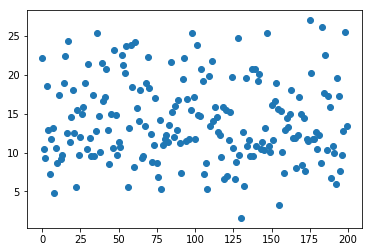

Unnamed: 0   131.000
TV             0.700
Radio         39.600
Newspaper      8.700
Sales          1.600
Name: 130, dtype: float64


In [14]:
outlier_check = data.Sales.reset_index()
plt.scatter(x=outlier_check.index, y=outlier_check.Sales)
plt.show()

print(data.iloc[130])

In [15]:
def plot_ind_vs_dep(df):
    for col in df.columns:
        print(col)
        plt.scatter(x=df[col], y=df.Sales)
        plt.show()

Unnamed: 0


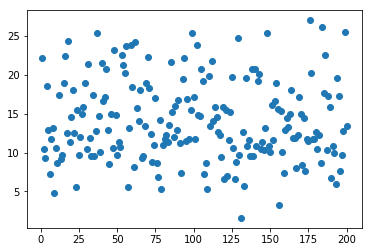

TV


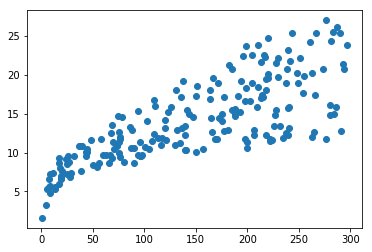

Radio


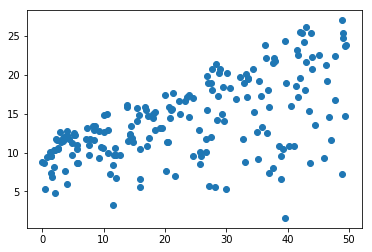

Newspaper


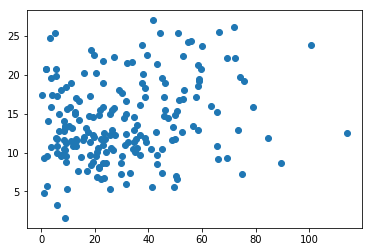

Sales


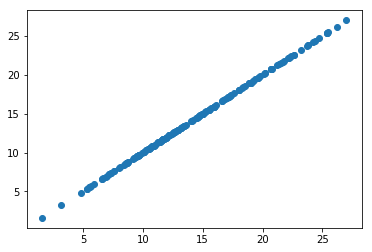

In [16]:
plot_ind_vs_dep(data)

Since radio and newspaper have the highest correlation (seen in the correlation matrix above) let's try dropping the newspaper variable since it is the least linear and is also the most correlated with radio


Coefficients: 
 [0.00635406 0.02363363]

Intercept: 
 2.1929850929340304

R-squared:
0.8766451770473039


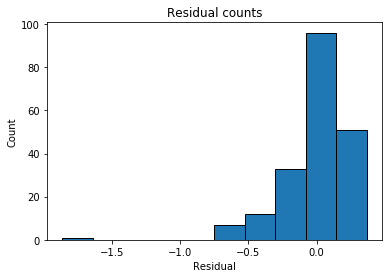

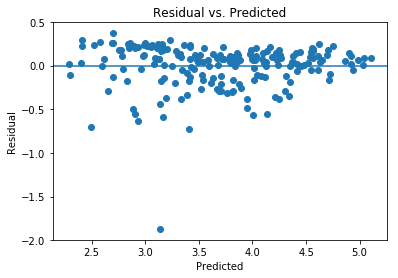

In [17]:
newX = X.drop('Newspaper', axis=1)
linregfunc(newX, sqroot)

In [18]:
findresidualoutlier(newX, sqroot)

     actual  predicted  residuals
130   1.265      3.133     -1.868
5     2.683      3.404     -0.721
155   1.789      2.493     -0.704
78    2.302      2.934     -0.632
126   2.569      3.162     -0.593


This was not an improvement let's keep it in there.  Let's try dropping the outlier that is popping up in each residual plot.


Coefficients: 
 [ 0.00615888  0.02472028 -0.00058402]

Intercept: 
 2.2239345185554695

R-squared:
0.9072906327060865


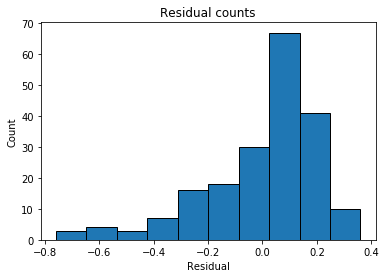

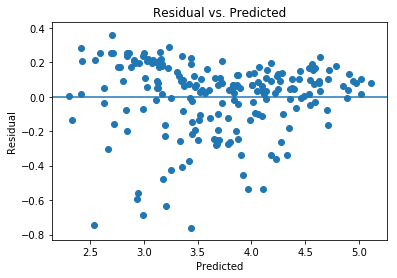

In [22]:
no_outlierX = X.drop(index=130)
no_outlierY = sqroot.drop(index=130)

linregfunc(no_outlierX, no_outlierY)

This is the best so far.  Let's try some feature scaling.

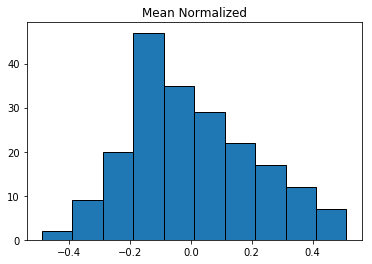

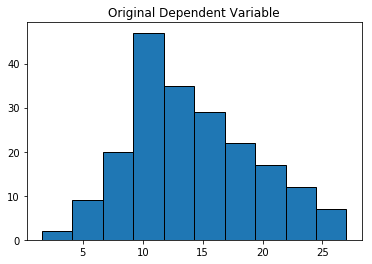


Coefficients: 
 [ 0.52207823  0.37864837 -0.01903312]

Intercept: 
 0.0018043480550847817

R-squared:
0.9095581620707601


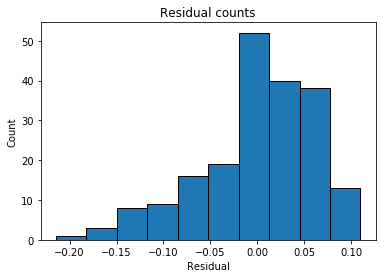

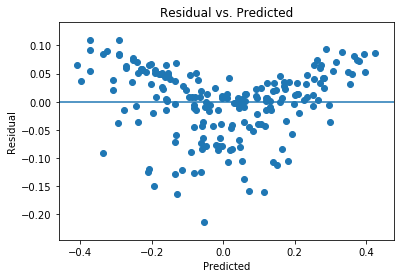

In [48]:
# ############################################################# #
#                         WINNER                                #
# ############################################################# #

# mean normalization
norm = data[['TV','Radio','Newspaper', 'Sales']]
norm = norm.apply(lambda x: (x - np.mean(x)) / (np.max(x) - np.min(x)))

plt.hist(norm.Sales, edgecolor='k')
plt.title('Mean Normalized')
plt.show()
plt.hist(data.Sales, edgecolor='k')
plt.title('Original Dependent Variable')
plt.show()

linregfunc(norm[['TV', 'Radio', 'Newspaper']].drop(index=130), norm.Sales.drop(index=130))

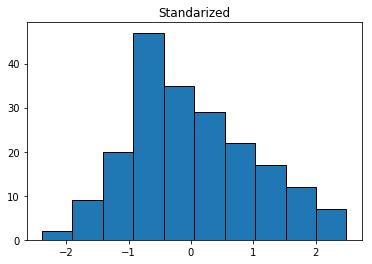

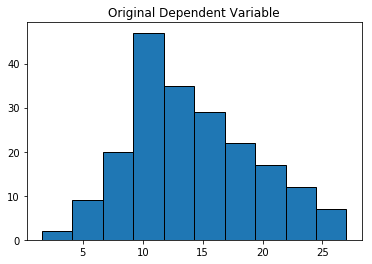


Coefficients: 
 [ 0.73793967  0.5517755  -0.01774822]

Intercept: 
 0.008806100746694927

R-squared:
0.90955816207076


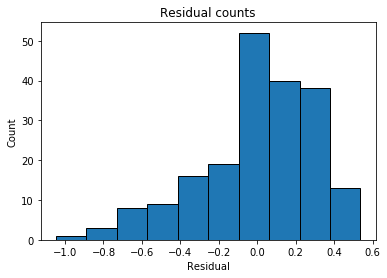

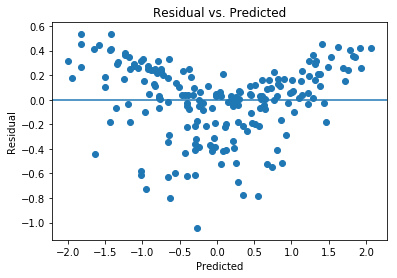

In [50]:
# standardizing
rescale = data[['TV','Radio','Newspaper', 'Sales']]
rescale = rescale.apply(lambda x: (x - np.mean(x)) / (np.std(x)))

plt.hist(rescale.Sales, edgecolor='k')
plt.title('Standarized')
plt.show()
plt.hist(data.Sales, edgecolor='k')
plt.title('Original Dependent Variable')
plt.show()

linregfunc(rescale[['TV', 'Radio', 'Newspaper']].drop(index=130), rescale.Sales.drop(index=130))

By dropping the outlier and using the mean normalization we have improved the homoscedasticity and mulitvariate non-normality.